In [1]:
import torch
from torch.autograd import Function, Variable
import torch.nn.functional as F
from torch import nn
from torch.nn.parameter import Parameter
import torch.optim as optim
from torch.nn.utils import parameters_to_vector
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import numpy.random as npr

import matplotlib
from matplotlib import pyplot as plt

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx
from mpc import casadi_control
#from mpc.dynamics import NNDynamics
#import mpc.util as eutil
from mpc.env_dx import frenet_kin_bicycle
from mpc.track.src import simple_track_generator, track_functions

import time
import os
import shutil
import pickle as pkl
import collections

import argparse

from tqdm import tqdm



In [2]:
class NN(nn.Module):
    def __init__(self, H):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(H + 3, 512)  
        self.fc2 = nn.Linear(512, 512)  
        self.output1 = nn.Linear(512, 8) 
        self.output2 = nn.Linear(512, 8) 

    def forward(self, c, x0):
        combined = torch.cat((c, x0), dim=1)
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        q = F.relu(self.output1(x)) + 0.0001
        p = self.output2(x)
        return q, p
    
def penalty_d(d, th, factor=100000):  
    overshoot_pos = (d - th).clamp(min=0)
    overshoot_neg = (-d - th).clamp(min=0)
    penalty_pos = torch.exp(overshoot_pos) - 1
    penalty_neg = torch.exp(overshoot_neg) - 1 
    return factor*(penalty_pos + penalty_neg)

def penalty_v(v, th, factor=100000):  
    penalty_pos = (v - th).clamp(min=0) ** 2
    return factor*penalty_pos

def penalty_ac(self, ac, factor=1000.):  
        penalty = (ac - ac_max).clamp(min=0) ** 2
        return factor*penalty

In [3]:
# Let's try to create a track 

track_density = 300
track_width = 0.5

gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'LONG_TRACK'

t = 0.3
init = [0,0,0]

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track
}.get(track_name, track_functions.demo_track)
    
track_function(gen, t, init)
    
gen.populatePointsAndArcLength()
gen.centerTrack()

track_coord = torch.from_numpy(np.vstack([gen.xCoords, gen.yCoords, gen.arcLength, gen.tangentAngle, gen.curvature]))

In [4]:
device = 'cpu' #to do

mpc_T = 25
n_batch = 32
H_curve = 80

l_r = 0.2
l_f = 0.2

v_max = 2.5
a_max = 3.
delta_max = 1.

ac_max = (0.7*v_max)**2 * delta_max / (l_r+l_f)

dt = 0.04

params = torch.tensor([l_r, l_f, track_width, v_max, ac_max, dt])

In [5]:
true_dx = frenet_kin_bicycle.FrenetKinBicycleDx(track_coord, params)

u_lower = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_upper = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T, n_batch, 1)

n_state = true_dx.n_state
n_ctrl = true_dx.n_ctrl

eps = 1
lqr_iter = 20
grad_method = GradMethods.AUTO_DIFF

#softplus_op = torch.nn.Softplus(10)

9


In [6]:
def sample_xinit(n_batch):
    def uniform(shape, low, high):
        r = high-low
        return torch.rand(shape)*r+low
    sigma = uniform(n_batch, 0.01, 20.)
    d = uniform(n_batch, -track_width*0.4, track_width*0.4)
    phi = uniform(n_batch, -0.4*np.pi, 0.4*np.pi)
    v = uniform(n_batch, 0., v_max)

    sigma_0 = sigma
    sigma_diff = sigma-sigma_0
    
    d_pen = penalty_d(d, 0.4*track_width)
    v_ub = penalty_v(v, v_max)
    
    k = true_dx.curv(sigma)
    ac = v**2 * 0.01 / (l_r+l_f)
    
    ac_ub = penalty_v(ac, ac_max)

    xinit = torch.stack((sigma, d, phi, v, sigma_0, sigma_diff, d_pen, v_ub, ac_ub), dim=1)
    return xinit


def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])

def get_loss_progress(x_init, dx, _Q, _p, mpc_T=mpc_T):    
        
        pred_x, pred_u, pred_objs = mpc.MPC(
            dx.n_state, dx.n_ctrl, mpc_T,
            u_lower=u_lower, u_upper=u_upper, u_init=u_init,
            lqr_iter=lqr_iter,
            verbose=0,
            exit_unconverged=False,
            detach_unconverged=False,
            linesearch_decay=.8,
            max_linesearch_iter=10,
            grad_method=grad_method,
            eps=eps,
            n_batch=n_batch,
        )(x_init, QuadCost(_Q, _p), dx)
        
        progress_loss = torch.mean(-pred_x[mpc_T-1,:,0] + pred_x[0,:,0])
                    
        return progress_loss
    
    
    
def get_curve_hor_from_x(x, track_coord, mpc_T):
    idx_track_batch = ((x[:,0]-track_coord[[2],:].T)**2).argmin(0)
    idcs_track_batch = idx_track_batch[:, None] + torch.arange(mpc_T)
    curvs = track_coord[4,idcs_track_batch].float()
    return curvs

def cost_to_batch_NN(q, p, n_batch, mpc_T):
    Q_batch = torch.zeros(n_batch, q.shape[1], q.shape[1])
    rows, cols = torch.arange(q.shape[1]), torch.arange(q.shape[1])  
    Q_batch[:, rows, cols] = q 
    Q_batch = Q_batch.unsqueeze(0).repeat(
                mpc_T, 1, 1, 1)    
    p_batch = p.unsqueeze(0).repeat(mpc_T, 1, 1)
    return Q_batch, p_batch

def cost_to_batch(q, p, n_batch, mpc_T):
    Q_batch = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
                mpc_T, n_batch, 1, 1
            )
    p_batch = p.unsqueeze(0).repeat(mpc_T, n_batch, 1)   
    return Q_batch, p_batch

def bound_params(q, p):
    q[:,0] = 0.0001
    q[:,4] = 0.0001
    p[:,0] = -0.0001
    q[:,1] = q[:,1] + 10.0
    q = q.clip(0.00001, 40.)
    p[:,0] = 0.0
    p[:,1] = 0.0
    p[:,2] = 0.0
    p[:,4] = 0.0
    p2 = p.clone()
    p2 = p.clip(-70.)
    p2[:,3] = p[:,3].clip(-70.)
    q2 = q.clone()
    return q2, p2

def inference_params(x_in, track_coord, H_curve, model, q_pen, p_pen, N, mpc_T):
    curvs = get_curve_hor_from_x(x_in, track_coord, H_curve)
    q, p = model(curvs, x_in[:,1:4])
    q = torch.cat((q[:,:6], q_pen, q[:,6:]), dim=1)
    p = torch.cat((p[:,:6], p_pen, p[:,6:]), dim=1)
    q2, p2 = bound_params(q, p) 
    Q_batch, p_batch = cost_to_batch_NN(q2, p2, N, mpc_T)
    return Q_batch, p_batch

In [7]:
env_params = true_dx.params
track_coord = track_coord.to(device)
dx = true_dx.__class__(track_coord,env_params)

q_penalty = .0001*torch.ones(3).to(device)
p_penalty = torch.ones(3).to(device)

model = NN(H_curve)
opt = optim.Adam(model.parameters(), lr=8e-4)
q_penalty_batch = q_penalty.unsqueeze(0).repeat(n_batch,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(n_batch,1)

9


In [8]:
for i in range(600):
    
    x_init = sample_xinit(n_batch).to(device)
    
    Q_batch, p_batch = inference_params(
        x_init, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        n_batch, mpc_T)
           
    loss = get_loss_progress(x_init, dx, Q_batch, p_batch)

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    print('Batch:', i , ' Progression with MPC_T=',mpc_T ,': ', -round(loss.item(), 4))

/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/autograd/__init__.py:411: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/alan/Desktop/envs/pao_env/lib/python3.8/site-packages/torch/_tensor.py:770: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 0  Progression with MPC_T= 25 :  0.8697
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 1  Progression with MPC_T= 25 :  1.4109
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 2  Progression with MPC_T= 25 :  1.4901
Batch: 3  Progression with MPC_T= 25 :  1.3576
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 4  Progression with MPC_T= 25 :  1.3481
[WARNING] pnqp warning: Did

[WARNING] pnqp warning: Did not converge
Batch: 83  Progression with MPC_T= 25 :  1.6857
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 84  Progression with MPC_T= 25 :  1.6176
Batch: 85  Progression with MPC_T= 25 :  1.5
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 86  Progression with MPC_T= 25 :  1.5383
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 87  Progression with MPC_T= 25 :  1.6211
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 88  Progression with MPC_T= 25 :  1.5772
[WARNING] pnqp warning: Did not converge
Batch: 89  Progression with MPC_T= 25 :  1.6022
[WARNING] pnqp warning: Did not converge
Batch: 90  Progression with MPC_T= 25 :  1.6825
[WARNING] pnqp warning: Did not converge
Batch: 91  Progression with MPC_T= 25 :  1.4238
[WARNING] pnqp warning: Did not conver

[WARNING] pnqp warning: Did not converge
Batch: 160  Progression with MPC_T= 25 :  1.4249
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 161  Progression with MPC_T= 25 :  16.3757
[WARNING] pnqp warning: Did not converge
Batch: 162  Progression with MPC_T= 25 :  76.7946
Batch: 163  Progression with MPC_T= 25 :  1.5759
Batch: 164  Progression with MPC_T= 25 :  1.4173
[WARNING] pnqp warning: Did not converge
Batch: 165  Progression with MPC_T= 25 :  1.4406
Batch: 166  Progression with MPC_T= 25 :  1.6995
Batch: 167  Progression with MPC_T= 25 :  1.4039
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 168  Progression with MPC_T= 25 :  1.6615
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 169  Progression with MPC_T= 25 :  1.2911
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 170  Prog

[WARNING] pnqp warning: Did not converge
Batch: 232  Progression with MPC_T= 25 :  1.4419
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 233  Progression with MPC_T= 25 :  18.1132
[WARNING] pnqp warning: Did not converge
Batch: 234  Progression with MPC_T= 25 :  1.4147
Batch: 235  Progression with MPC_T= 25 :  1.5853
Batch: 236  Progression with MPC_T= 25 :  1.4082
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 237  Progression with MPC_T= 25 :  1.6201
[WARNING] pnqp warning: Did not converge
Batch: 238  Progression with MPC_T= 25 :  1.4467
[WARNING] pnqp warning: Did not converge
Batch: 239  Progression with MPC_T= 25 :  1.6881
[WARNING] pnqp warning: Did not converge
Batch: 240  Progression with MPC_T= 25 :  1.4594
[WARNING] pnqp warning: Did not converge
Batch: 241  Progression with MPC_T= 25 :  1.4596
Batch: 242  Progr

Batch: 305  Progression with MPC_T= 25 :  1.5397
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 306  Progression with MPC_T= 25 :  1.5211
Batch: 307  Progression with MPC_T= 25 :  1.6485
[WARNING] pnqp warning: Did not converge
Batch: 308  Progression with MPC_T= 25 :  1.4752
Batch: 309  Progression with MPC_T= 25 :  1.4878
[WARNING] pnqp warning: Did not converge
Batch: 310  Progression with MPC_T= 25 :  1.5606
[WARNING] pnqp warning: Did not converge
Batch: 311  Progression with MPC_T= 25 :  1.408
Batch: 312  Progression with MPC_T= 25 :  1.5652
Batch: 313  Progression with MPC_T= 25 :  1.5116
[WARNING] pnqp warning: Did not converge
Batch: 314  Progression with MPC_T= 25 :  1.5125
[WARNING] pnqp warning: Did not converge
Batch: 315  Progression with MPC_T= 25 :  1.5407
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] p

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 385  Progression with MPC_T= 25 :  1.692
[WARNING] pnqp warning: Did not converge
Batch: 386  Progression with MPC_T= 25 :  1.4512
Batch: 387  Progression with MPC_T= 25 :  1.5923
Batch: 388  Progression with MPC_T= 25 :  1.6104
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 389  Progression with MPC_T= 25 :  1.7038
Batch: 390  Progression with MPC_T= 25 :  1.5318
[WARNING] pnqp warning: Did not converge
Batch: 391  Progression with MPC_T= 25 :  1.2528
Batch: 392  Progression with MPC_T= 25 :  1.559
[WARNING] pnqp warning: Did not converge
Batch: 393  Progression with MPC_T= 25 :  1.4757
Batch: 394  Progression with MPC_T= 25 :  1.3021
[WARNING] pnqp warning: Did not converge
Batch: 395  Progression with MPC_T= 25 :  1.183
[WARNING] pnqp warning: Did not converge
Batch: 396  Progression with MPC_T= 25 :  1.1521
Batch: 397  Progression with MPC_T= 25 :  1.49

Batch: 467  Progression with MPC_T= 25 :  1.5179
[WARNING] pnqp warning: Did not converge
Batch: 468  Progression with MPC_T= 25 :  1.3553
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 469  Progression with MPC_T= 25 :  1.467
[WARNING] pnqp warning: Did not converge
Batch: 470  Progression with MPC_T= 25 :  1.4531
[WARNING] pnqp warning: Did not converge
Batch: 471  Progression with MPC_T= 25 :  1.5271
Batch: 472  Progression with MPC_T= 25 :  1.3971
Batch: 473  Progression with MPC_T= 25 :  1.4881
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 474  Progression with MPC_T= 25 :  1.4327
[WARNING] pnqp warning: Did not converge
Batch: 475  Progression with MPC_T= 25 :  1.5596
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did

Batch: 541  Progression with MPC_T= 25 :  1.5973
Batch: 542  Progression with MPC_T= 25 :  1.5977
Batch: 543  Progression with MPC_T= 25 :  1.4891
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 544  Progression with MPC_T= 25 :  1.5704
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 545  Progression with MPC_T= 25 :  1.4991
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 546  Progression with MPC_T= 25 :  1.4564
[WARNING] pnqp warning: Did not converge
Batch: 547  Progression with MPC_T= 25 :  1.4324
Batch: 548  Progression with MPC_T= 25 :  1.4827
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
Batch: 549  Progression with MPC_T

In [9]:
N_test = 1
mpc_T_test = mpc_T

In [10]:
#x_init_test = sample_xinit(N_test)

# Below you can put any initial state you want (any that make sense)
sigma = torch.tensor(0.01)

d = torch.tensor(0.0)
d_pen = penalty_d(d, 0.5*track_width*0.75)

v = torch.tensor(0.01)
v_ub = penalty_v(v, v_max*0.95)

ac = true_dx.curv(torch.tensor([sigma])) * v**2
ac_ub = penalty_ac(ac, torch.tensor(ac_max)*0.95)

sigma_0 = sigma
sigma_diff = sigma-sigma_0

x_init_test = torch.tensor([[sigma, d, -.0, 0.01, sigma_0, 
                             sigma_diff, d_pen, v_ub, ac_ub]])

In [11]:
# Added here the bounds of U
u_lower_test = torch.tensor([-a_max, -delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_upper_test = torch.tensor([a_max, delta_max]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)
u_init= torch.tensor([0.1, 0.0]).unsqueeze(0).unsqueeze(0).repeat(mpc_T_test, N_test, 1)

In [12]:
N_sim_total = 300
x_simulated = torch.zeros((N_sim_total,1,9))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

    Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)

    x_mpc_test, u_mpc_test, objs_mpc_test = mpc.MPC(
                n_state, n_ctrl, mpc_T_test,
                u_lower=u_lower_test, u_upper=u_upper_test, u_init=u_init,
                lqr_iter=30,
                verbose=0,
                exit_unconverged=False,
                detach_unconverged=True,
                linesearch_decay=.8,
                max_linesearch_iter=10,
                grad_method=grad_method,
                eps=.5,
                n_batch=N_test,
            )(x_sim, QuadCost(Q_test_batch, p_test_batch), dx)

    x_simulated[i] = x_mpc_test[1]
    x_simulated[i,0,4] = x_simulated[i,0,0]
    x_simulated[i,0,5] = 0.

It: 1 x= [[ 0.01  0.   -0.    0.01  0.01  0.    0.    0.    0.  ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 2 x= [[0.01  0.    0.    0.117 0.01  0.    0.    0.    0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 3 x= [[ 0.015 -0.    -0.     0.22   0.015  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping throu

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 22 x= [[ 0.683 -0.053 -0.138  1.386  0.683  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All example

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 42 x= [[ 2.372 -0.037 -0.038  2.224  2.372  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 43 x= [[ 2.46  -0.047 -0.071  2.156  2.46   0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 44 x= [[ 2.546 -0.059 -0.102  2.096  2.546  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* 

[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 70 x= [[4.72  0.044 0.254 2.109 4.72  0.    0.    0.    0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 71 x= [[4.799 0.064 0.305 2.164 4.799 0.    0.    0.    0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 72 x= [[4.879 0.061 0.265 2.103 4.879 0.    0.    0.    0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples 

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 104 x= [[ 7.357 -0.014 -0.534  1.942  7.357  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 105 x= [[ 7.432 -0.03  -0.507  1.944  7.432  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 106 x= [[ 7.504 -0.048 -0.519  1.964  7.504  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.

[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 127 x= [[8.942 0.073 0.155 2.236 8.942 0.    0.    0.    0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 128 x= [[ 9.046  0.101 -0.027  2.271  9.046  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converg

[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 150 x= [[1.1098e+01 8.0000e-03 1.4300e-01 2.0140e+00 1.1098e+01 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 151 x= [[11.176  0.026  0.163  2.049 11.176  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 152 x= [[11.249 -0.013 -0.112  1.929 11.249  0.     0.     0.     0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* 

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 183 x= [[13.465 -0.073  0.071  1.853 13.465  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 184 x= [[13.549 -0.097  0.116  1.733 13.549  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 185 x= [[13.639 -0.111  0.234  1.853 13.639  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 186 x= [[13.735 -0.089  0.484  1.914 13.735  0.     0.     0.     0.   ]]
[WA

[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 215 x= [[15.862 -0.065  0.099  1.907 15.862  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 216 x= [[15.942 -0.06   0.144  1.92  15.942  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 217 x= [[16.019 -0.088  0.052  2.015 16.019  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 244 x= [[ 1.836600e+01 -6.700000e-02 -8.600000e-02  1.900000e+00  1.836600e+01
   0.000000e+00  0.000000e+00  0.000000e+00  1.872032e+03]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 245 x= [[ 1.8432e+01 -4.2000e-02 -6.0000e-03  1.7800e+00  1.8432e+01  0.0000e+00
   0.0000e+00  0.0000e+00  0.0000e+00]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 246 x= [[18.497 -0.026 -0.029  1.772 18.497  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backprop

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 276 x= [[ 2.061e+01 -1.500e-02 -3.820e-01  1.749e+00  2.061e+01  0.000e+00
   0.000e+00  0.000e+00  0.000e+00]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 277 x= [[20.673 -0.04  -0.537  1.764 20.673  0.     0.     0.     0.   ]]
[WARNING] pnqp warning: Did not converge
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 278 x= [[20.732 -0.067 -0.622  1.74  20.732  0.     0.     0.     0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 279 x= [[20.79  -0.093 -0.647  1.745 20.79   0.     0.     0.     0.   ]]
LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.
It: 280 x

In [13]:
u_mpc_test[0]

tensor([[-0.0576,  0.0801]], grad_fn=<SelectBackward0>)

In [14]:
def get_nearest_index(point_f, ref_path):
    return ((point_f[0] - ref_path[2,:])**2).argmin()
    
def compute_x_coord(point_f, ref_path, nearest_index):
    return ref_path[0,nearest_index] - point_f[1]*torch.sin(ref_path[3,nearest_index])

def compute_y_coord(point_f, ref_path, nearest_index):
    return ref_path[1,nearest_index] + point_f[1]*torch.cos(ref_path[3,nearest_index])

def frenet_to_cartesian(point_f, ref_path):     
    nearest_index = get_nearest_index(point_f, ref_path)
    x = compute_x_coord(point_f, ref_path, nearest_index)
    y = compute_y_coord(point_f, ref_path, nearest_index)
    
    return torch.tensor([x, y])

In [15]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

In [16]:
x_plot = np.array(x_list)
y_plot = np.array(y_list)

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


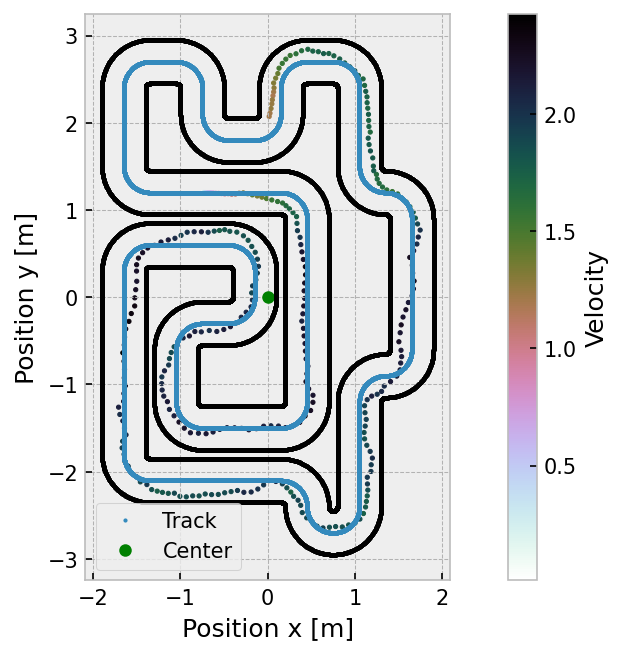

In [17]:
from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,3].detach(), cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 
#ax.plot(x_plot, y_plot)

#ax.scatter(x_plot[23:25], y_plot[23:25], color='red', s=4)

#ax.scatter(x_plot, y_plot, s=4, color='red')

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [18]:
curvsp = dx.curv(x_simulated[:250,0,0]).detach()

Text(0, 0.5, '1-d*curve')

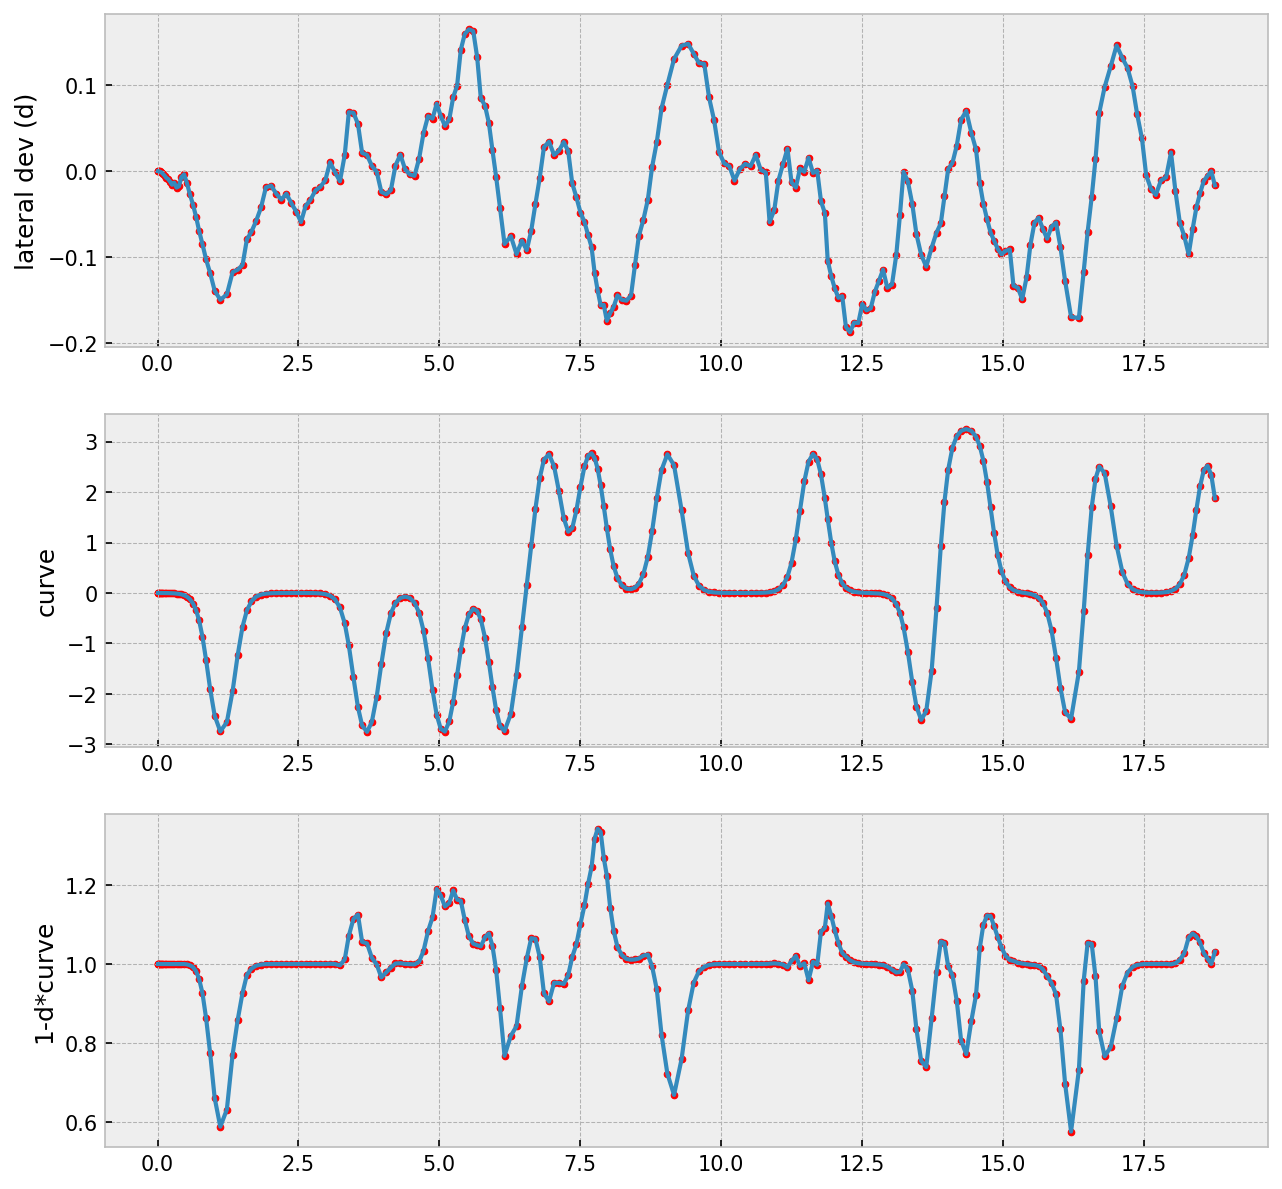

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(10,10), dpi=150)
axs[0].plot(x_simulated[:250,0,0].detach(), 
         x_simulated[:250,0,1].detach())
axs[0].scatter(x_simulated[:250,0,0].detach(), 
         x_simulated[:250,0,1].detach(), s=10, color='red')
axs[0].set_ylabel('lateral dev (d)')

axs[1].plot(x_simulated[:250,0,0].detach(), 
         curvsp)
axs[1].scatter(x_simulated[:250,0,0].detach(), 
         curvsp, s=10, color='red')
axs[1].set_ylabel('curve')

axs[2].plot(x_simulated[:250,0,0].detach(), 
         1 - curvsp*x_simulated[:250,0,1].detach())
axs[2].scatter(x_simulated[:250,0,0].detach(), 
         1 - curvsp*x_simulated[:250,0,1].detach(), s=10, color='red')
axs[2].set_ylabel('1-d*curve')



In [59]:
from mpc import casadi_control
from importlib import reload
reload(casadi_control)

<module 'mpc.casadi_control' from '/home/alan/Desktop/Research/Code/race_application/mpc/casadi_control.py'>

In [60]:
control = casadi_control.CasadiControl(track_coord, params.numpy())

dc = 3 #number constraints
df = 2 #number of states we artificially added like sigma_0, sigma_diff
dx = n_state #number states taken from the dynamics (including penalties and sigma_o/sigma_diff)
du = n_ctrl #number control inputs

N_sim_total = 200
x_simulated = torch.zeros((N_sim_total,1,9))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

for i in range(1,N_sim_total):

    x_sim = x_simulated[i-1]
    print('It:', i, 'x=', x_sim.detach().numpy().round(3))

    Q_test_batch, p_test_batch = inference_params(
        x_sim, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)
    
    test_q = torch.diag(Q_test_batch[0,0]).detach().numpy()
    test_p = p_test_batch[0,0].detach().numpy()

    sol = control.mpc_casadi_with_constraints(
        test_q,test_p,x_sim.detach().numpy(),mpc_T_test,df,dc,dx,du)
    
    u_mpc_test = sol[-du*mpc_T_test:]
    x_mpc_test = sol[:-du*mpc_T_test]
    u_mpc_test = u_mpc_test.reshape(mpc_T_test,du)
    x_mpc_test = x_mpc_test.reshape(mpc_T_test+1,dx-dc-df)

    x_simulated[i,0,:4] = torch.tensor(x_mpc_test[1])
    x_simulated[i,0,4] = torch.tensor(x_simulated[i,0,0])
    x_simulated[i,0,5] = 0.

9
It: 1 x= [[ 0.01  0.   -0.    0.01  0.01  0.    0.    0.    0.  ]]
curv start
curv end
curv start
curv end
curv start
curv end


RuntimeError: .../casadi/core/sx_instantiator.cpp:457: Sparsities of v and vdef must match. Got v: 6x1 and vdef: 7x1.

x_init: -0.7499999999999999
y_init: 1.1999999999999995
yaw_init: 0.0
Total Arc Length: 26.8655890901819


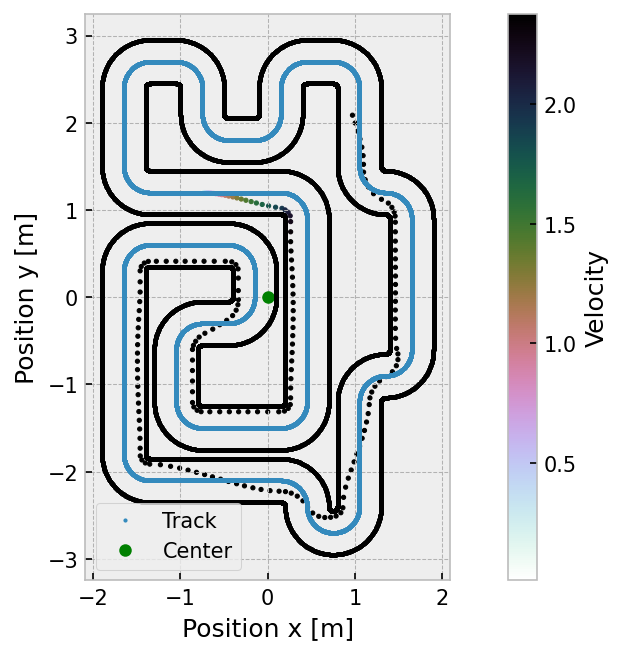

In [50]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

x_plot = np.array(x_list)
y_plot = np.array(y_list)

from matplotlib import cm


fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

custom_cmap = plt.get_cmap('cubehelix').reversed()
sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,0,3].detach(), cmap=custom_cmap, s=4)

cbar = plt.colorbar(sct)
cbar.set_label('Velocity') 
#ax.plot(x_plot, y_plot)

#ax.scatter(x_plot[23:25], y_plot[23:25], color='red', s=4)

#ax.scatter(x_plot, y_plot, s=4, color='red')

print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [54]:
x_simulated.numpy()[:,0,3]

array([0.01      , 0.09      , 0.17      , 0.25      , 0.33      ,
       0.41000003, 0.49000004, 0.57000005, 0.65000004, 0.73      ,
       0.81      , 0.89      , 0.96999997, 1.05      , 1.13      ,
       1.21      , 1.2900001 , 1.3700001 , 1.4500002 , 1.5300002 ,
       1.6100003 , 1.6900003 , 1.7700003 , 1.8500004 , 1.9300004 ,
       2.0100005 , 2.0900004 , 2.1700003 , 2.2500002 , 2.3300002 ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.3746514 , 2.375     , 2.375     , 2.375     ,
       2.375     , 2.375     , 2.375     , 2.375     , 2.375  

In [22]:
Q_test_batch.shape

torch.Size([25, 1, 11, 11])

### Debug problem in a specific state with specific control

In [44]:
x_simulated[95,0,0]

tensor(7.2683, grad_fn=<SelectBackward0>)

In [ ]:
x_simulated[21:25]

In [26]:
x_simulated[21:25,0,0]

tensor([0.9674, 1.1156, 1.3268, 1.5536], grad_fn=<SelectBackward0>)

In [34]:
dx.curv(x_simulated[22:26,0,0])

tensor([-0.0000, -0.0000, -3.3333, -3.3333], grad_fn=<ViewBackward0>)

In [51]:
x_try = torch.tensor([[ 7.7,   -0.081, -0.789,  0.59,   7.7,    0.,     0.,     0.   ]])

In [52]:
#x_try = torch.tensor([[4.4648e+00, 1.3147e-01, 1.2658e-01, 1.6995e+00, 4.4648e+00, 0.0000e+00,
#         2.4290e-05, 4.4661e-03, 1.2244e-04]])

In [53]:
Q_test_batch, p_test_batch = inference_params(
        x_try, track_coord, H_curve, model, 
        q_penalty_batch, p_penalty_batch, 
        N_test, mpc_T_test)

In [54]:
x_mpc_test, u_mpc_test, objs_mpc_test = mpc.MPC(
        n_state, n_ctrl, mpc_T_test,
        u_lower=u_lower_test, u_upper=u_upper_test, u_init=u_init,
        lqr_iter=60,
        verbose=0,
        exit_unconverged=False,
        detach_unconverged=True,
        linesearch_decay=.4,
        max_linesearch_iter=10,
        grad_method=grad_method,
        eps=.5,
        n_batch=N_test,
    )(x_try, QuadCost(Q_test_batch, p_test_batch), dx)

LQR Warning: All examples did not converge to a fixed point.
Detaching and *not* backpropping through the bad examples.


In [56]:
u_mpc_test[0]

tensor([[-0.9626,  0.7000]], grad_fn=<SelectBackward0>)

In [49]:
Q_test_batch[0,0]

tensor([[1.0000e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-04, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-04, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-04,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000

In [50]:
p2_test[0]

NameError: name 'p2_test' is not defined

In [29]:
sigma_t = 1.4224
d_t = -0.1262

In [119]:
idx_track = ((track_coord[2] - sigma_t)**2).argmin()

In [ ]:
- point_f[1]*torch.sin(ref_path[3,nearest_index])

In [120]:
track_coord[:,453]

tensor([ 0.4500,  0.7600,  1.5112, -1.5708,  0.0000], dtype=torch.float64)

In [122]:
track_coord[:,454]

tensor([ 0.4500,  0.7567,  1.5146, -1.5708,  0.0000], dtype=torch.float64)

In [30]:
1. - d_t*true_dx.curv(torch.tensor([sigma_t]))

tensor([1.])

In [143]:
l_r,l_f = torch.unbind(true_dx.params)
beta = torch.atan(l_r/(l_r+l_f)*torch.tan(torch.tensor(-0.7)))

In [146]:
phi = torch.tensor(0.3914)

In [51]:
objs_mpc_test

tensor([-2118.8635], grad_fn=<CopySlices>)

In [141]:
u_mpc_test[0]

tensor([[ 0.2991, -0.7000]], grad_fn=<SelectBackward0>)

In [28]:
x_mpc_test[1,0]

tensor([ 1.4224, -0.1262,  0.9851,  1.4871,  1.2851,  0.1373,  0.0000,  0.0000],
       grad_fn=<SelectBackward0>)

In [40]:
q2_test*torch.hstack((x_mpc_test[0,0], u_mpc_test[0,0]))**2 + p2_test*torch.hstack((x_mpc_test[0,0], u_mpc_test[0,0]))

tensor([[ 6.6049e-06,  7.2251e-02,  8.4640e-07, -7.8857e+00,  6.6049e-06,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -4.2228e+00, -3.1622e-02]],
       grad_fn=<AddBackward0>)

In [34]:
(q2_test*torch.hstack((x_mpc_test[0,0], u_mpc_test[0,0]))**2 + p2_test*torch.hstack((x_mpc_test[0,0], u_mpc_test[0,0]))).sum()

tensor(5.2632, grad_fn=<SumBackward0>)

In [41]:
p2_test

tensor([[  0.0000,   0.0000,   0.0000, -13.0128,   0.0000,  -8.8466,   1.0000,
           1.0000, -14.2250,   2.0384]], grad_fn=<CopySlices>)

In [46]:
q2_test

tensor([[1.0000e-04, 1.0000e+01, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
         1.0000e-04, 1.0000e-04, 8.6453e+01, 1.0000e-04]],
       grad_fn=<CloneBackward0>)

In [54]:
dx.forward(x_try, u_mpc_test[0])

tensor([[ 1.5120, -0.1723,  1.0260,  1.8458,  1.2683,  0.2437,  0.0000,  0.0000]],
       grad_fn=<StackBackward0>)

In [155]:
def forward(state, u):
    softplus_op = torch.nn.Softplus(20)
    squeeze = state.ndimension() == 1
    if squeeze:
        state = state.unsqueeze(0)
        u = u.unsqueeze(0)
    if state.is_cuda and not dx.params.is_cuda:
        dx.params = dx.params.cuda()

    l_r,l_f = torch.unbind(dx.params)

    a, delta = torch.unbind(u, dim=1)

    sigma, d, phi, v, sigma_0, sigma_diff, d_pen, v_ub = torch.unbind(state, dim=1)
    beta = torch.atan(l_r/(l_r+l_f)*torch.tan(delta))

    dsigma = v*(torch.cos(phi+beta)/(1.-dx.curv(sigma)*d))
    dd = v*torch.sin(phi+beta)
    dphi = v/l_f*torch.sin(beta)-dx.curv(sigma)*v*(torch.cos(phi+beta)/(1-dx.curv(sigma)*d))
    dv = a
    #print(sigma)
    #print(self.curv(sigma))

    sigma = sigma + dx.dt * dsigma
    d = d + dx.dt * dd
    phi = phi + dx.dt * dphi
    v = v + dx.dt * dv
    sigma_0 = sigma_0                   # we need to carry it on
    sigma_diff = sigma - sigma_0

    d_pen = dx.penalty_d(d)

    v_ub = dx.penalty_v(v)

    #d_lb = softplus_op(-d - 0.5*self.track_width)
    #d_ub = softplus_op(d - 0.5*self.track_width)
    #v_lb = softplus_op(-v + 0)
    #v_ub = softplus_op(v - self.v_max)

    state = torch.stack((sigma, d, phi, v, sigma_0, sigma_diff, d_pen, v_ub), 1)

    return state

In [156]:
forward(x_try, u_mpc_test[0])

tensor([[ 1.5120, -0.1880,  1.0260,  1.8458,  1.2683,  0.2437, 45.9194,  0.0000]],
       grad_fn=<StackBackward0>)

In [34]:
p_test.shape

torch.Size([1, 11])

### Executing with casadi

In [31]:
N_sim_total = 40
x_simulated = np.zeros((N_sim_total,1,8))

x_simulated[0] = x_init_test[0]

q_penalty_batch = q_penalty.unsqueeze(0).repeat(N_test,1)
p_penalty_batch = p_penalty.unsqueeze(0).repeat(N_test,1)

control = casadi_control.CasadiControl(track_coord)

for i in range(1,N_sim_total):
      
    
    x_sim = x_simulated[i-1]
    print(x_sim)
        
    curvs_test = get_curve_hor_from_x(torch.tensor(x_sim).float(), track_coord, H_curve)
    q_test, p_test = model(curvs_test, torch.tensor(x_sim[:,1:4]).float())
    q_test = torch.cat((q_test[:,:6], q_penalty_batch, q_test[:,6:]), dim=1)
    p_test = torch.cat((p_test[:,:6], p_penalty_batch, p_test[:,6:]), dim=1)

    q2_test, p2_test = bound_params(q_test, p_test)

    Q_test_batch, p_test_batch = cost_to_batch_NN(q2_test, p2_test, N_test, mpc_T_test) 

            
 
    sol = control.mpc_casadi(q_test[0].detach().numpy(),
                             p_test[0].detach().numpy(),
                             x_sim,
                             mpc_T_test,
                             2,
                             2,
                             n_state,
                             n_ctrl,
                             track_width,
                             2.)
    
    u = sol[-n_ctrl*mpc_T_test:]
    x = sol[:-n_ctrl*mpc_T_test]
    u_mpc_test = u.reshape(mpc_T_test,n_ctrl)
    x_mpc_test = x.reshape(mpc_T_test+1,n_state-2)
        
    x_simulated[i] = x_mpc_test[1]
    x_simulated[i,0,4] = x_simulated[i,0,0]
    x_simulated[i,0,5] = 0.

[[ 9.99999978e-03  0.00000000e+00 -0.00000000e+00  9.99999978e-03
   9.99999978e-03  0.00000000e+00  7.88897369e-03  7.88897369e-03
   2.27792785e-10]]
curv start
curv end
curv start
curv end
curv start
curv end


RuntimeError: .../casadi/core/sparsity.cpp:431: Assertion "x.size2()==y.size1()" failed:
Matrix product with incompatible dimensions. Lhs is 15x10 and rhs is 9x9.

In [ ]:
x_list = []
y_list = []

for i in range(x_simulated.shape[0]):
    xy = frenet_to_cartesian(x_simulated[i,0,:2], track_coord)
    x_list.append(xy[0].numpy())
    y_list.append(xy[1].numpy())

In [ ]:
x_plot = np.array(x_list)
y_plot = np.array(y_list)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
gen.plotPoints(ax)
#gen.pointAtArcLength(0)
#gen.writePointsToYaml('../tracks/' + track_name + '.yaml', track_density)

ax.scatter(x_plot, y_plot, s=4, color='red')
#ax.scatter(0.1471, 0.8741, s=7, color='green')
#ax.scatter(0.4500, 0.5100, s=100, color='blue')



print('x_init: ' + str(gen.xCoords[0]))
print('y_init: ' + str(gen.yCoords[0]))
print('yaw_init: ' + str(gen.tangentAngle[0]))
print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
plt.show()

In [125]:
ds = torch.arange(-1,1,0.01)

In [120]:
pens = 1000*softplus_op(-torch.tensor(ds)-0.5*track_width).numpy() + 1000*softplus_op(torch.tensor(ds)-0.5*track_width).numpy()

In [127]:
penalty_d(ds, 0.2, 10)

tensor([6.4000e+00, 6.2410e+00, 6.0840e+00, 5.9290e+00, 5.7760e+00, 5.6250e+00,
        5.4760e+00, 5.3290e+00, 5.1840e+00, 5.0410e+00, 4.9000e+00, 4.7610e+00,
        4.6240e+00, 4.4890e+00, 4.3560e+00, 4.2250e+00, 4.0960e+00, 3.9690e+00,
        3.8440e+00, 3.7210e+00, 3.6000e+00, 3.4810e+00, 3.3640e+00, 3.2490e+00,
        3.1360e+00, 3.0250e+00, 2.9160e+00, 2.8090e+00, 2.7040e+00, 2.6010e+00,
        2.5000e+00, 2.4010e+00, 2.3040e+00, 2.2090e+00, 2.1160e+00, 2.0250e+00,
        1.9360e+00, 1.8490e+00, 1.7640e+00, 1.6810e+00, 1.6000e+00, 1.5210e+00,
        1.4440e+00, 1.3690e+00, 1.2960e+00, 1.2250e+00, 1.1560e+00, 1.0890e+00,
        1.0240e+00, 9.6100e-01, 9.0000e-01, 8.4100e-01, 7.8400e-01, 7.2900e-01,
        6.7600e-01, 6.2500e-01, 5.7600e-01, 5.2900e-01, 4.8400e-01, 4.4100e-01,
        4.0000e-01, 3.6100e-01, 3.2400e-01, 2.8900e-01, 2.5600e-01, 2.2500e-01,
        1.9600e-01, 1.6900e-01, 1.4400e-01, 1.2100e-01, 1.0000e-01, 8.1000e-02,
        6.4000e-02, 4.9000e-02, 3.6000e-

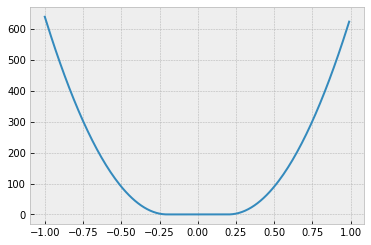

In [129]:
plt.plot(ds.numpy(), penalty_d(ds, 0.2, 1000).numpy())